# How to train your own word vector embeddings using Gensim

Many tasks require embeddings or domain-specific vocabulary that pre-trained models based on a generic corpus may not represent well or at all. Standard word2vec models are not able to assign vectors to out-of-vocabulary words and instead use a default vector that reduces their predictive value.

E.g., when working with industry-specific documents, the vocabulary or its usage may change over time as new technologies or products emerge. As a result, the embeddings need to evolve as well. In addition, corporate earnings releases use nuanced language not fully reflected in Glove vectors pre-trained on Wikipedia articles.

In this notebook we illustrate the more performant gensim adaptation of the code provided by the word2vec authors. 

To illustrate the word2vec network architecture, we use the Financial News data that we first introduced in chapter 14 on Topic Modeling. 

## Imports

In [1]:
%matplotlib inline 
import warnings
from time import time
from collections import Counter
from pathlib import Path
import pandas as pd
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cdist, cosine

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import LineSentence
from sklearn.decomposition import IncrementalPCA

### Settings

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('float_format', '{:,.2f}'.format)
np.random.seed(42)

### Paths

In [3]:
news_path = Path('data', 'fin_news')
data_path = news_path / 'data'
analogy_path = Path('data', 'analogies-en.txt')

In [4]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

## Model Configuration

In [5]:
gensim_path = news_path / 'gensim'
if not gensim_path.exists():
    gensim_path.mkdir(parents=True, exist_ok=True)

In [6]:
NGRAMS = 3           # Longest ngram in text
MIN_FREQ = 100
WINDOW_SIZE = 5
EMBEDDING_SIZE = 300
NEGATIVE_SAMPLES = 20
EPOCHS = 1

In [7]:
FILE_NAME = f'articles_{NGRAMS}_grams.txt'

## Sentence Generator

In [8]:
sentence_path = data_path / FILE_NAME
sentences = LineSentence(str(sentence_path))

## Train word2vec Model

In [9]:
start = time()
model = Word2Vec(sentences, 
                 sg=1, # set to 1 for skipgram; CBOW otherwise
                 size=EMBEDDING_SIZE, 
                 window=WINDOW_SIZE,
                 min_count=MIN_FREQ, 
                 negative=NEGATIVE_SAMPLES, 
                 workers=8,
                 iter=EPOCHS, 
                 alpha=0.05)

# persist model
model.save(str(gensim_path / 'word2vec.model'))

# persist word vectors
model.wv.save(str(gensim_path / 'word_vectors.bin'))
print('Duration:', format_time(time() - start))

Duration: 00:02:50


## Evaluate results

In [10]:
cat_dict = {'capital-common-countries':'Capitals',
            'capital-world':'Capitals RoW',
            'city-in-state':'City-State',
            'currency':'Currency',
            'family':'Famliy',
            'gram1-adjective-to-adverb':'Adj-Adverb',
            'gram2-opposite':'Opposite',
            'gram3-comparative':'Comparative',
            'gram4-superlative':'Superlative',
            'gram5-present-participle':'Pres. Part.',
            'gram6-nationality-adjective':'Nationality',
            'gram7-past-tense':'Past Tense',
            'gram8-plural':'Plural',
            'gram9-plural-verbs':'Plural Verbs',
            'total':'Total'}

In [11]:
def accuracy_by_category(acc, detail=True):
    results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in acc]
    results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
    results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
    if detail:
        print(results.sort_values('average', ascending=False))
    return results.loc[results.category=='total', ['correct', 'incorrect', 'average']].squeeze().tolist()

In [12]:
# gensim computes accuracy based on source text files
detailed_accuracy = model.wv.accuracy(analogy_path.as_posix(), case_insensitive=True)

In [13]:
# get accuracy per category
summary = accuracy_by_category(detailed_accuracy)
print('Base Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

                       category  correct  incorrect  average
0      capital-common-countries      322         98     0.77
10  gram6-nationality-adjective      732        324     0.69
1                 capital-world      678        512     0.57
7             gram3-comparative      307        563     0.35
14                        total     2941       5639     0.34
4                        family       37         73     0.34
8             gram4-superlative       87        185     0.32
11             gram7-past-tense      332        790     0.30
3                      currency       24        104     0.19
9      gram5-present-participle      108        492     0.18
12                 gram8-plural       54        252     0.18
13           gram9-plural-verbs       77        429     0.15
2                 city-in-state      153       1203     0.11
6                gram2-opposite       10        172     0.05
5     gram1-adjective-to-adverb       20        442     0.04
Base Accuracy: Correct 2

In [14]:
most_sim = model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=20)
pd.DataFrame(most_sim, columns=['token', 'similarity'])

,token,similarity
0,meghan,0.43
1,kings,0.42
2,princess,0.40
3,winery,0.40
4,keller,0.40
5,angela,0.39
6,curry,0.39
7,daly,0.39
8,roman,0.39
9,duke,0.38


In [15]:
counter = Counter(sentence_path.read_text().split())

In [16]:
most_common = pd.DataFrame(counter.most_common(), columns=['token', 'count'])
most_common = most_common[most_common['count']> MIN_FREQ]
most_common['p'] = np.log(most_common['count'])/np.log(most_common['count']).sum()

In [17]:
similars = pd.DataFrame()
for token in np.random.choice(most_common.token, size=10, p=most_common.p):
    similars[token] = [s[0] for s in model.wv.most_similar(token)]
similars.T

,0,1,2,3,4,5,6,7,8,9
shall_sale,jurisdiction_offer,solicitation_sale_unlawful,prior_registration_qualification,sell_solicitation_offer,offer_solicitation,shall_constitute_offer,buy_shall,solicitation_offer_buy,does_constitute_offer,offer_sell_solicitation
identiv,apptio,ooma,juniper_networks,asure_software,palo_alto_networks,interdigital,cheetah_mobile,servicenow,orbcomm,guidewire
liquidate,illiquid,liquidating,dispose,defaulted,prior_registration_qualification,offload,divest,bondholders,insolvent,jurisdiction_offer
selectively,tumor_microenvironment,inhibit,receptors,cancer_cells,t_cells,inhibition,antigen,allogeneic,molecules,monoclonal_antibodies
voting,votes,voted,vote,votes_cast,ballots,polling_stations,election,polling_station,ballot,electing
payment,payments,paid,installments,installment,repayment,plus_accrued_unpaid,alipay,accrued_unpaid,pay,accrue
nationality,kuciak,sarkozy,arrest_warrant,raped,deport,attempted_murder,deportations,minors,forcibly,immigrant
arpu,postpaid,rgus,subscriber,subscriber_base,churn,subscribers,acv,telephony,ocf,arr
beijing_monitoring_desk,editing_kim_coghill,sam_holmes,editing_jacqueline_wong,himani_sarkar,kim_coghill,editing_muralikumar_anantharaman,shri_navaratnam,christopher_cushing,shanghai_newsroom,editing_sam_holmes


## Continue Training

In [18]:
accuracies = [summary]
best_accuracy = summary[-1]
for i in range(1, 10):
    start = time()
    model.train(sentences, epochs=1, total_examples=model.corpus_count)
    detailed_accuracy = model.wv.accuracy(analogy_path)
    accuracies.append(accuracy_by_category(detailed_accuracy, detail=False))
    print(f'{i:02} | Duration: {format_time(time() - start)} | Accuracy: {accuracies[-1][-1]:.2%} ')
    if accuracies[-1][-1] > best_accuracy:
        model.save(str(gensim_path / f'word2vec_{i:02}.model'))
        model.wv.save(str(gensim_path / f'word_vectors_{i:02}.bin'))
        best_accuracy = accuracies[-1][-1]
    (pd.DataFrame(accuracies, 
                 columns=['correct', 'wrong', 'average'])
     .to_csv(gensim_path / 'accuracies.csv', index=False))
model.wv.save(str(gensim_path / 'word_vectors_final.bin'))

01 | Duration: 00:02:48 | Accuracy: 39.17% 
02 | Duration: 00:02:46 | Accuracy: 40.05% 
03 | Duration: 00:02:54 | Accuracy: 40.79% 
04 | Duration: 00:02:58 | Accuracy: 40.27% 
05 | Duration: 00:02:39 | Accuracy: 40.55% 
06 | Duration: 00:02:41 | Accuracy: 40.66% 
07 | Duration: 00:02:40 | Accuracy: 41.82% 
08 | Duration: 00:02:44 | Accuracy: 40.80% 
09 | Duration: 00:02:34 | Accuracy: 41.26% 


## Evaluate Best Model

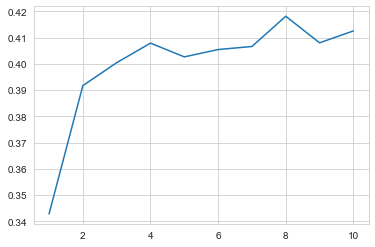

In [19]:
pd.DataFrame(accuracies, columns=['correct', 'wrong', 'average'], index=list(range(1, len(accuracies) + 1))).average.plot();

In [20]:
best_model = Word2Vec.load((gensim_path / 'word2vec_06.model').as_posix())

In [21]:
# gensim computes accuracy based on source text files
detailed_accuracy = best_model.wv.accuracy(analogy_path.as_posix(), case_insensitive=True)

In [22]:
# get accuracy per category
summary = accuracy_by_category(detailed_accuracy)
print('Base Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

                       category  correct  incorrect  average
0      capital-common-countries      356         64     0.85
1                 capital-world      911        279     0.77
10  gram6-nationality-adjective      767        289     0.73
14                        total     3582       4998     0.42
7             gram3-comparative      344        526     0.40
4                        family       41         69     0.37
11             gram7-past-tense      351        771     0.31
12                 gram8-plural       86        220     0.28
2                 city-in-state      372        984     0.27
8             gram4-superlative       71        201     0.26
3                      currency       32         96     0.25
9      gram5-present-participle      125        475     0.21
13           gram9-plural-verbs       72        434     0.14
5     gram1-adjective-to-adverb       40        422     0.09
6                gram2-opposite       14        168     0.08
Base Accuracy: Correct 3

In [23]:
results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in detailed_accuracy]
results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
results['category'] = results.category.map(cat_dict)
results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
results = results.rename(columns=str.capitalize).set_index('Category')
total = results.loc['Total']
results = results.drop('Total')

In [24]:
most_sim = best_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=20)
pd.DataFrame(most_sim, columns=['token', 'similarity'])

,token,similarity
0,lewis,0.36
1,monarch,0.36
2,queen,0.35
3,kate,0.34
4,william,0.34
5,prince,0.34
6,son,0.34
7,james,0.34
8,street,0.33
9,paul,0.33


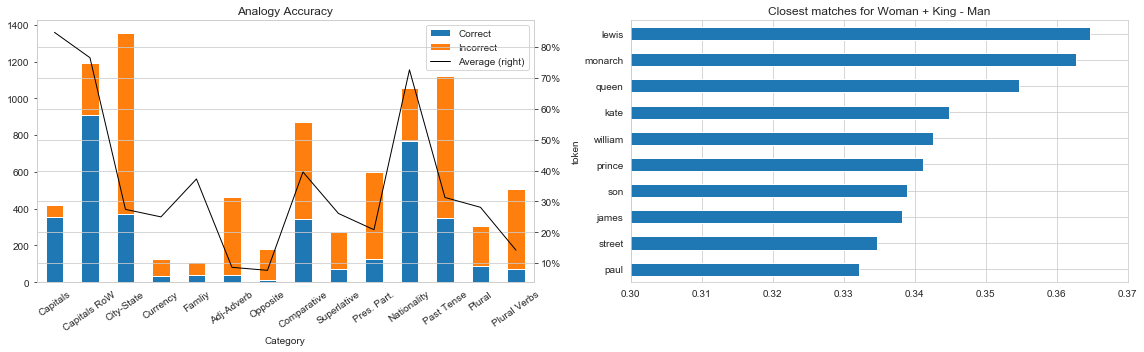

In [25]:
fig, axes = plt.subplots(figsize=(16, 5), ncols=2)

axes[0] = results.loc[:, ['Correct', 'Incorrect']].plot.bar(stacked=True, ax=axes[0]
                                                           , title='Analogy Accuracy')
ax1 = results.loc[:, ['Average']].plot(ax=axes[0], secondary_y=True, lw=1, c='k', rot=35)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

(pd.DataFrame(most_sim, columns=['token', 'similarity'])
 .set_index('token').similarity
 .sort_values().tail(10).plot.barh(xlim=(.3, .37), ax=axes[1], title='Closest matches for Woman + King - Man'))
fig.tight_layout();

In [26]:
counter = Counter(sentence_path.read_text().split())

In [27]:
most_common = pd.DataFrame(counter.most_common(), columns=['token', 'count'])
most_common = most_common[most_common['count']> MIN_FREQ]
most_common['p'] = np.log(most_common['count'])/np.log(most_common['count']).sum()

In [28]:
similars = pd.DataFrame()
for token in np.random.choice(most_common.token, size=10, p=most_common.p):
    similars[token] = [s[0] for s in best_model.wv.most_similar(token)]
similars.T

,0,1,2,3,4,5,6,7,8,9
risks_uncertainties,cause_actual,factors,uncertainties,known_unknown_risks_uncertainties,differ_materially,differ_materially_expressed_implied,risks,statements,assumptions,involve
wheeler_real_estate,trust,gladstone,infrareit,reit,redwood,gi_partners,matthew,essex,agf,riocan
culinary,chef,dining,restaurant,wine,coffee,beverage,attractions,garden,guests,educational
expensive,cheaper,costly,cheap,cheapest,difficult,more,like,consuming,easier,complicated
fy,compensation_mln_vs,mln,versus,qtrly,sees_fy,ceo,total,cfo,quarter,compensation
modern,architecture,ai,contemporary,functionality,innovative,elegant,cutting_edge,innovations,mission,platform
advocacy,nonprofit,education,groups,practice,advocate,philanthropy,advocates,awareness,mentoring,lgbt
worsening,severe,dire,symptoms,diarrhea,acute,suffer,plight,influx,escalating,fever
hawkish,dovish,fed,rate_hikes,yellen,federal_reserve,monetary_policy,powell,hike,policy,tone
an,the,very,it,a,called,appears,earlier,was,this,scenario


In [29]:
similars.T.iloc[:5, :5].to_csv('figures/most_similar.csv')

## Resources

- [Distributed representations of words and phrases and their compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
- [Efficient estimation of word representations in vector space](https://arxiv.org/pdf/1301.3781.pdf?)
- [Sebastian Ruder's Blog](http://ruder.io/word-embeddings-1/)